In [ ]:
# Open folder /Volumes/Exodus/Data/PETRAW/Training/Training/Video and convert all mp4 into images with same resolution
# and save them in /Volumes/Exodus/Data/PETRAW/Training/Training/Images/{vid_name}

import os
import cv2
import numpy as np
import sys

def extract_frames(video_path, vid_name, output_folder):
    vidcap = cv2.VideoCapture(video_path)
    success,image = vidcap.read()
    count = 0
    while success:
        # should be 'frame00000000.png'
        cv2.imwrite(f'{output_folder}/{vid_name[5:]}frame{str(count).zfill(8)}.png', image)     # save frame as PNG file
        success,image = vidcap.read()
        count += 1
    print(f'Extracted {count} frames from {video_path}')

In [ ]:
video_folder = '/Volumes/Exodus/Data/PETRAW/Training/Training/Video'
output_folder = '/Volumes/Exodus/Data/PETRAW/Training/Training/Images'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
for root, _, files in os.walk(video_folder):
    for file in files:
        if file.endswith('.mp4') and not file.startswith('.'):
            vid_name = os.path.splitext(file)[0]
            vid_path = os.path.join(root, file)
            output_path = os.path.join(output_folder, vid_name)
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            extract_frames(vid_path, vid_name, output_path)

In [ ]:
# Rename every single image in the subfolders here to remove the first _ character
for root, _, files in os.walk(output_folder):
    for file in files:
        if file.startswith('_'):
            os.rename(os.path.join(root, file), os.path.join(root, file[1:]))

['140', '141', '035', '021', '037', '143', '026', '146', '147', '027', '033', '025', '144', '018', '024', '057', '080', '094', '137', '122', '136', '095', '081', '042', '068', '120', '109', '082', '096', '041', '055', '051', '045', '092', '125', '131', '119', '118', '130', '124', '087', '078', '050', '052', '132', '127', '133', '090', '084', '047', '062', '076', '102', '103', '088', '075', '061', '115', '114', '100', '128', '060', '074', '048', '058', '110', '111', '105', '065', '071', '067', '107', '099', '066', '001', '149', '014', '028', '016', '002', '017', '013', '007', '010', '038', '039', '011', '005']
['frame00000000.png', 'frame00000001.png', 'frame00000002.png', 'frame00000003.png', 'frame00000004.png', 'frame00000005.png', 'frame00000006.png', 'frame00000007.png', 'frame00000008.png', 'frame00000009.png', 'frame00000010.png', 'frame00000011.png', 'frame00000012.png', 'frame00000013.png', 'frame00000014.png', 'frame00000015.png', 'frame00000016.png', 'frame00000017.png', 'fra

KeyboardInterrupt: 

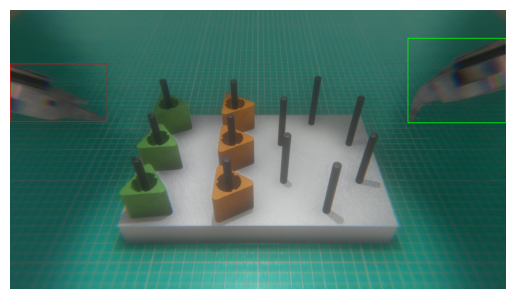

: 

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gc  # Garbage collection module


# Function to create YOLO annotations from masks
def create_annotations(
    images_path_base, masks_path, labels_path, batch_size=50, n=None
):
    # For each folder inside images_path, create a corresponding folder inside labels_path
    dirs = os.listdir(images_path_base)
    # Skip specified folders
    folders_to_skip = ["008", "034"]
    dirs = [d for d in dirs if d not in folders_to_skip]
    
    # Q: Explain the above line of code?
    # A: The above line of code is filtering out the folders that are in the folders_to_skip list.
    
    print(dirs)


    for folder in dirs:
        labels_folder = os.path.join(labels_path, folder)
        images_folder = os.path.join(images_path_base, folder)
        if not os.path.exists(labels_folder):
            os.makedirs(labels_folder)

        if n is not None:
            image_files = sorted(
                [
                    f
                    for f in os.listdir(images_folder)
                    if f.endswith(".png") and not f.startswith(".")
                ]
            )[:n]
        else:
            image_files = sorted(
                [
                    f
                    for f in os.listdir(images_folder)
                    if f.endswith(".png") and not f.startswith(".")
                ]
            )

        # Remove files that already have corresponding annotation files
        image_files = [
            f
            for f in image_files
            if not os.path.exists(
                os.path.join(labels_folder, f.replace(".png", ".txt"))
            )
        ]

        # Process images in batches
        for i in range(0, len(image_files), batch_size):
            batch_files = image_files[i : i + batch_size]
            for image_file in batch_files:
                image_path = os.path.join(images_folder, image_file)
                mask_file = os.path.join(masks_path, folder, image_file)
                print(mask_file)
                mask_path = os.path.join(masks_path, mask_file)

                label_file = os.path.join(
                    labels_folder, image_file.replace(".png", ".txt")
                )

                if not os.path.exists(mask_path):
                    continue

                with open(label_file, "w") as lf:
                    mask = cv2.imread(mask_path)

                    # Separate the red and green components
                    mask_hsv = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)
                    lower_red = np.array([0, 50, 50])
                    upper_red = np.array([10, 255, 255])
                    red_mask = cv2.inRange(mask_hsv, lower_red, upper_red)

                    lower_green = np.array([50, 50, 50])
                    upper_green = np.array([70, 255, 255])
                    green_mask = cv2.inRange(mask_hsv, lower_green, upper_green)

                    # Process red (left tool)
                    contours_red, _ = cv2.findContours(
                        red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
                    )
                    for contour in contours_red:
                        contour = contour.squeeze()  # Remove extra dimension
                        if (
                            len(contour.shape) == 1
                        ):  # Single point, duplicate to make a box
                            contour = np.array([contour, contour])
                        normalized_contour = []
                        for point in contour:
                            x = point[0] / red_mask.shape[1]
                            y = point[1] / red_mask.shape[0]
                            normalized_contour.extend([x, y])
                        lf.write(f"0 {' '.join(map(str, normalized_contour))}\n")

                    # Process green (right tool)
                    contours_green, _ = cv2.findContours(
                        green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
                    )
                    for contour in contours_green:
                        contour = contour.squeeze()  # Remove extra dimension
                        if (
                            len(contour.shape) == 1
                        ):  # Single point, duplicate to make a box
                            contour = np.array([contour, contour])
                        normalized_contour = []
                        for point in contour:
                            x = point[0] / green_mask.shape[1]
                            y = point[1] / green_mask.shape[0]
                            normalized_contour.extend([x, y])
                        lf.write(f"1 {' '.join(map(str, normalized_contour))}\n")

                # Use matplotlib to draw the images with bounding box
                print(image_path)
                image = cv2.imread(image_path)
                for contour in contours_red:
                    x, y, w, h = cv2.boundingRect(contour)
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
                for contour in contours_green:
                    x, y, w, h = cv2.boundingRect(contour)
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.axis("off")
                # plt.show()

            # Force garbage collection after each batch
            gc.collect()

        print("Annotations created in YOLO format in", labels_path)


create_annotations(
    images_path_base="/Volumes/Exodus/Data/PETRAW/Training/Training/Images/",
    masks_path="/Volumes/Exodus/Data/PETRAW/Training/Training/Segmentation/",
    labels_path="/Volumes/Exodus/Data/PETRAW/labels/train/",
    n=None,
)